In [2]:
<a id='data1'></a>
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,precision_recall_curve,roc_auc_score,confusion_matrix,roc_curve

pd.set_option('display.max_row', 10000)
pd.set_option('display.max_columns', 1000)

# Split predictors into categorical and continuous features.
def get_cat_cont_cols(df,cols):
    cat_cols = []
    cont_cols = []
    for col in cols:
        if df[col].dtype == 'object':
            cat_cols.append(col)
        else:
            cont_cols.append(col)
    return cat_cols,cont_cols

# Find null and duplicate values from data frame.
def findNullValues(df):
    null_catcol = []
    null_contcol = []
    null_vals = df.isnull().sum().sort_values()
    df_null = pd.DataFrame({'nullcols':null_vals.index, 'countval':null_vals.values})
    df_null = df_null[df_null.countval > 0]
    print ("Null features with values :",df_null)
    print ("Duplicated values :", df_null.duplicated().sum())
    nullcolumns = list(df_null.nullcols)
    null_catcol,null_contcol = get_cat_cont_cols(df,df_null.nullcols)
    return null_catcol,null_contcol

# Fill NA values with appropirate values for categorical and continuos features
def fillNAvalues(df,null_catcols,null_contcols):
    df_nullcatcols =  df[null_catcols].fillna('NA')
    df_nullcontcols = df[null_contcols]
    df_nullcontcols.fillna(df_nullcontcols.mean(),inplace=True)
    #my_imputer = SimpleImputer()
    #imputed_df_x_cont = my_imputer.fit_transform(df_x[nullcontcols])
    colns = list(set(df.columns) - set(null_catcols) - set(null_contcols))
    df_nafill = pd.concat([df[colns],df_nullcatcols,df_nullcontcols],axis=1)
    return df_nafill


# Find outliers in continuous features and normalize all featurea into log scale
def get_outliers_scale(df,cols):
    for col in cols:
        stat = df[col].describe()
        # print(stat)
        IQR = stat['75%'] - stat['25%']
        upper = stat['75%'] + 1.5 * IQR
        lower = stat['25%'] - 1.5 * IQR
        print('The upper and lower bounds of {} for suspected outliers are {} and {}.'.format(col,upper, lower))
        print "Values less than lower bound :" , len(df[df[col] < lower])
        print "Values greater than upper  bound : ", len(df[df[col] > upper])
        # converting to log scale
        df[col]=np.log1p(df[col])
    return df[cols]

# Label encode categorical features
def encode_label(df,cols):
    le = preprocessing.LabelEncoder()
    for col in cols:
        df[col] = np.log1p(le.fit_transform(df[col]))
    return df[cols]


data_file = "/Users/salil/Downloads/training_car.csv"
df_read = pd.read_csv(data_file)
df_read = df_read.drop(['AUCGUART','PRIMEUNIT','Nationality','VNZIP1','VNST','BYRNO','WheelTypeID','PurchDate','VehYear'],axis=1)

total_columns = df_read.columns
catcols,contcols =  get_cat_cont_cols(df_read, total_columns)    
print ("Categorical columns: ", catcols)

uid = ['RefId']
target = ['IsBadBuy']
contcols = list(set(contcols) - set(uid) - set(target))
features = catcols + contcols 
print ("Numerical columns after target and id removal: ", contcols)

df_read.Transmission[df_read.Transmission == 'Manual'] = 'MANUAL'
df_read.Color[df_read.Color == 'NOT AVAIL'] = 'NA'
df_read.Color[df_read.Color == 'OTHER'] = 'NA'
df_read.TopThreeAmericanName[df_read.TopThreeAmericanName == 'OTHER'] = 'NA'

null_cat_cols,null_cont_cols = findNullValues(df_read)
df_new = fillNAvalues(df_read, null_cat_cols, null_cont_cols)

('Categorical columns: ', ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Size', 'TopThreeAmericanName'])
('Numerical columns after target and id removal: ', ['WarrantyCost', 'MMRAcquisitionAuctionAveragePrice', 'VehOdo', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'VehicleAge', 'MMRCurrentRetailCleanPrice', 'VehBCost', 'MMRCurrentAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'MMRCurrentRetailAveragePrice', 'IsOnlineSale', 'MMRCurrentAuctionCleanPrice'])


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

('Null features with values :',     countval                           nullcols
10         5                               Size
11         5               TopThreeAmericanName
12         8                           SubModel
13         8                              Color
14         9                       Transmission
15        18      MMRAcquisitonRetailCleanPrice
16        18    MMRAcquisitionAuctionCleanPrice
17        18  MMRAcquisitionAuctionAveragePrice
18        18   MMRAcquisitionRetailAveragePrice
19       315      MMRCurrentAuctionAveragePrice
20       315        MMRCurrentAuctionCleanPrice
21       315       MMRCurrentRetailAveragePrice
22       315         MMRCurrentRetailCleanPrice
23      2360                               Trim
24      3174                          WheelType)
('Duplicated values :', 0)


/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


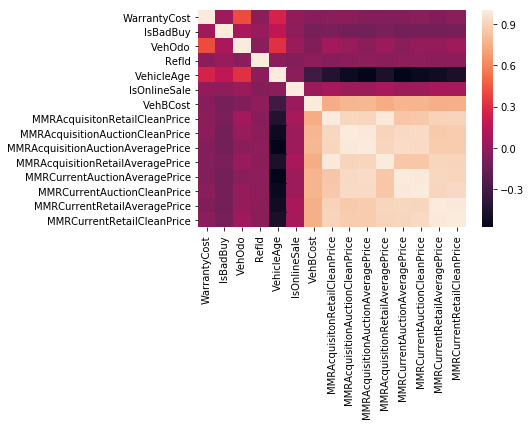

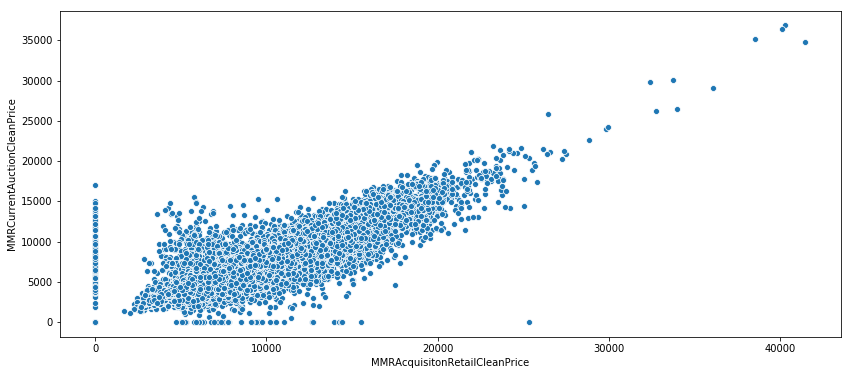

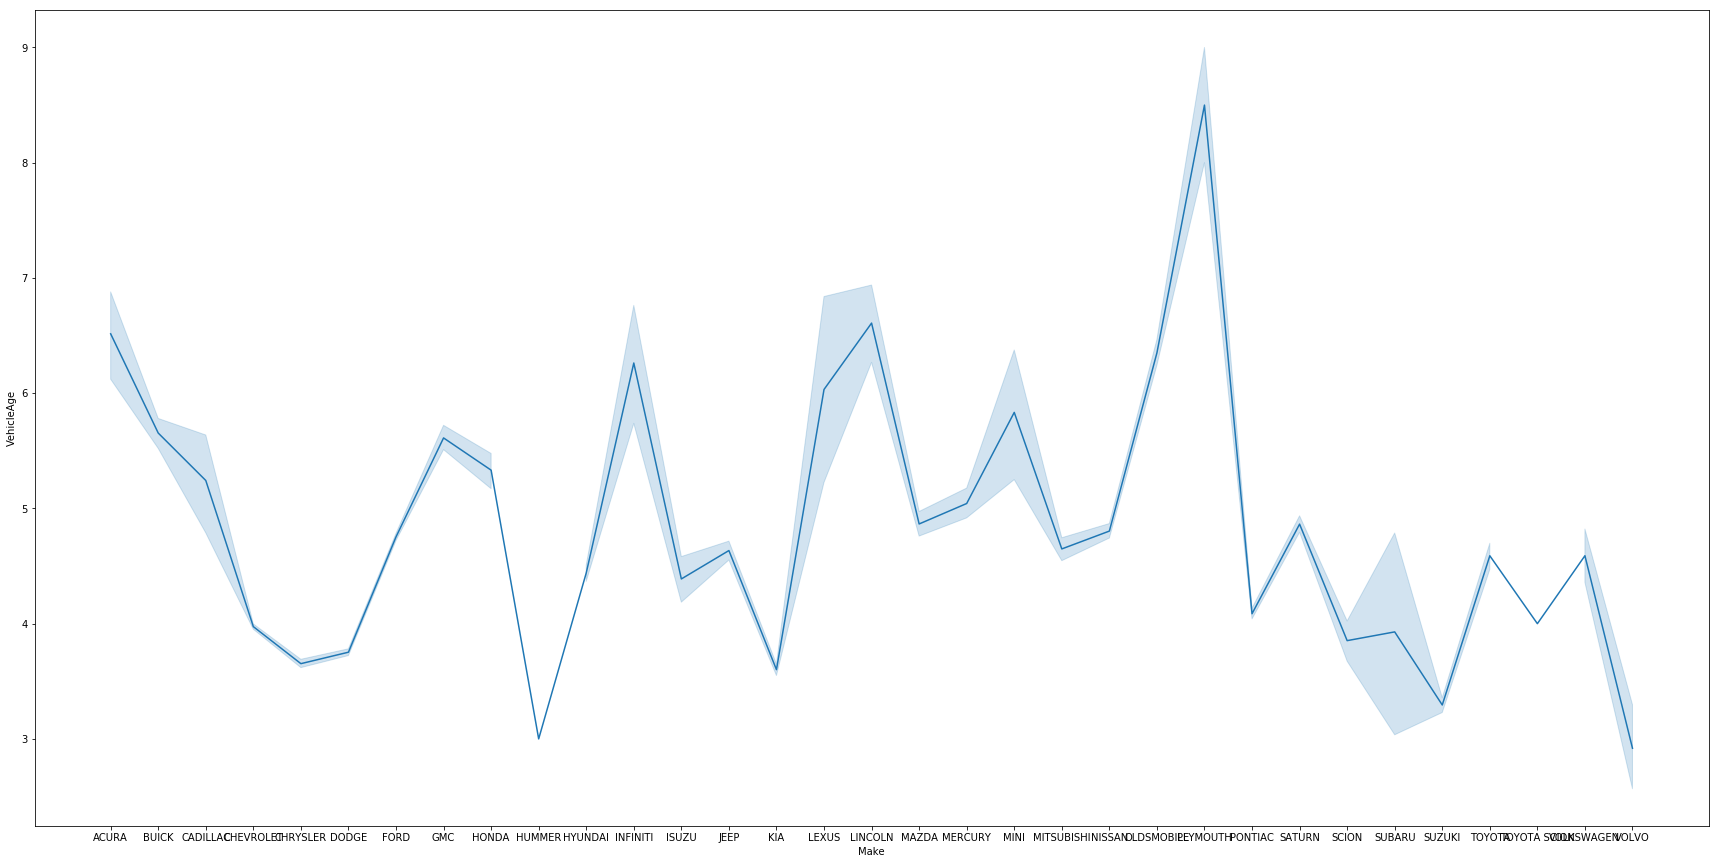

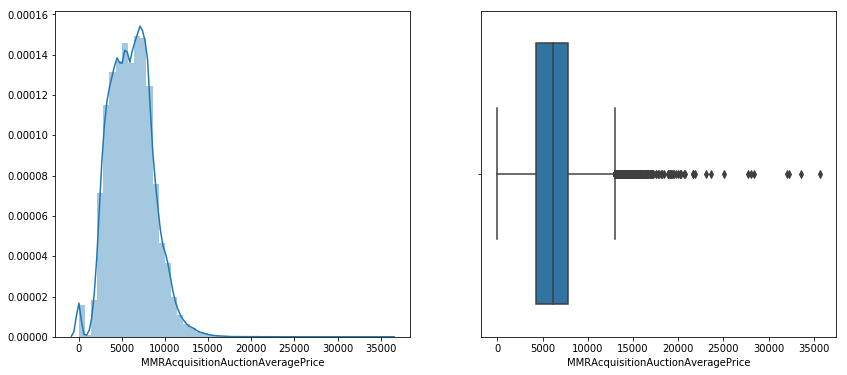

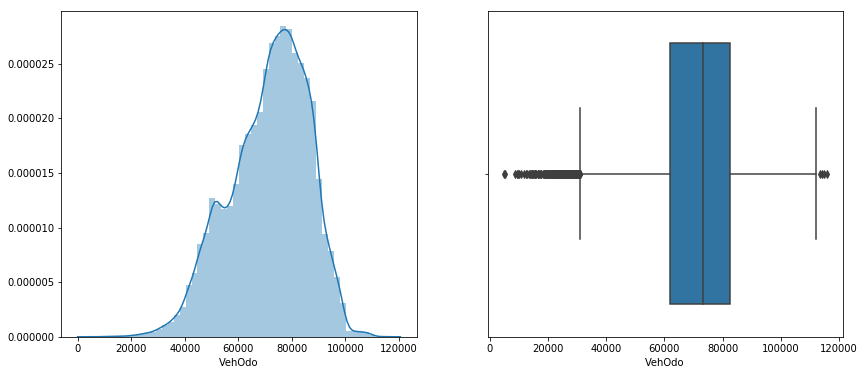

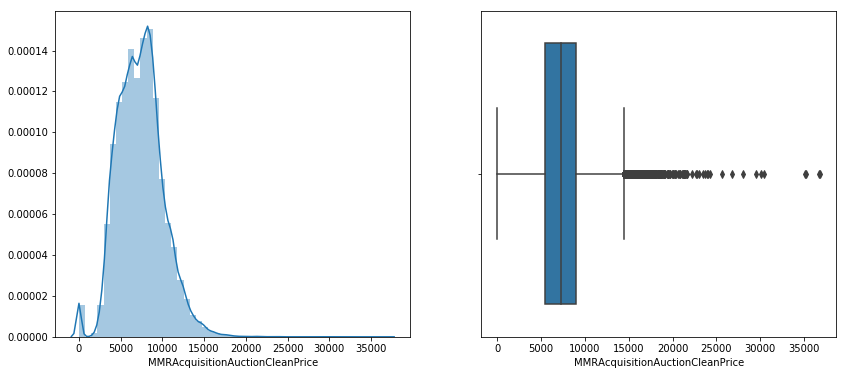

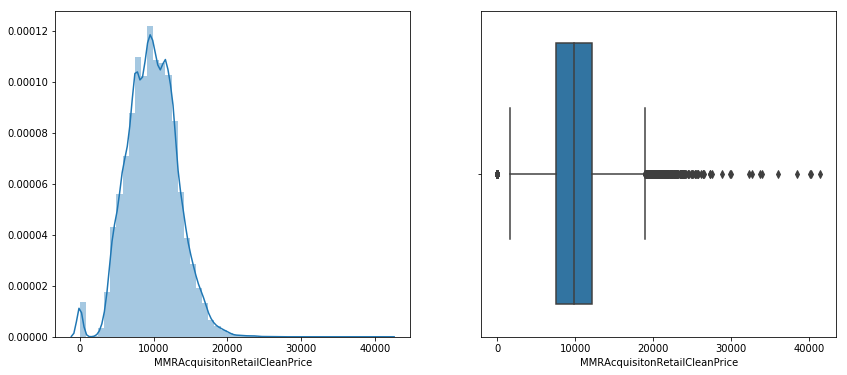

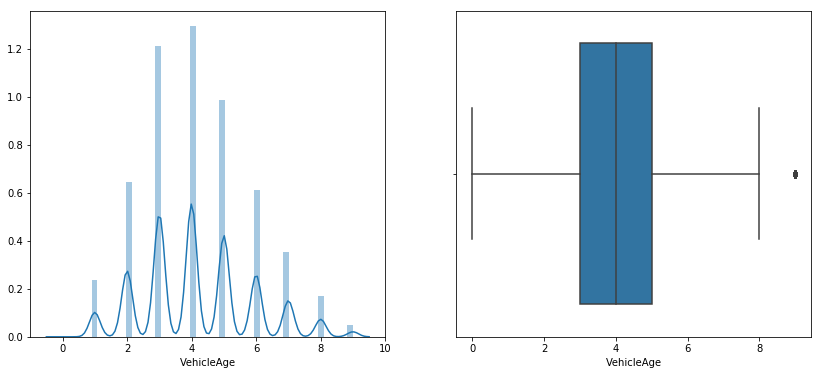

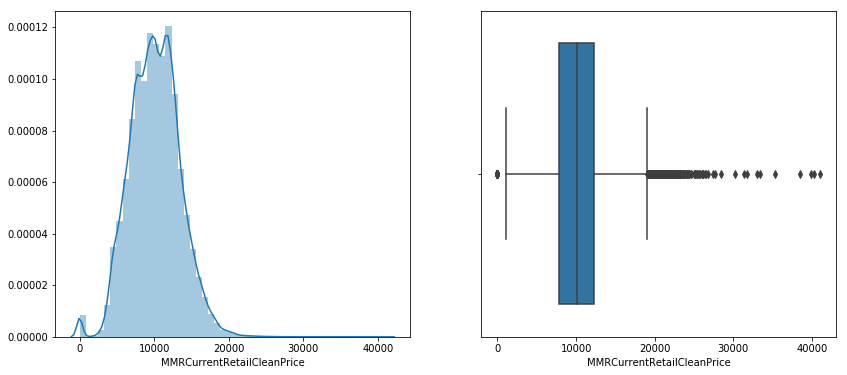

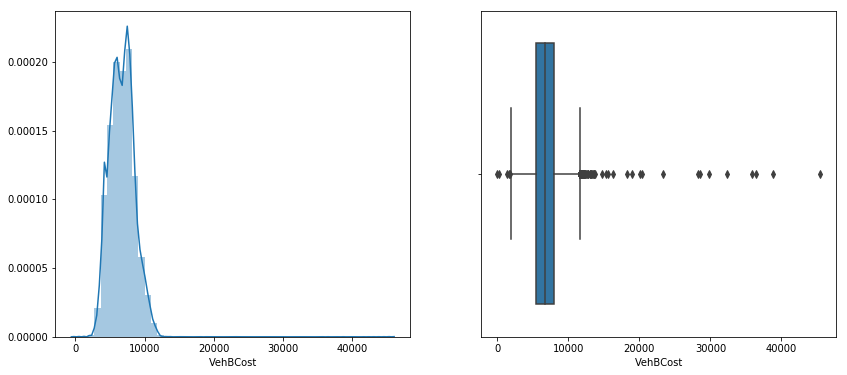

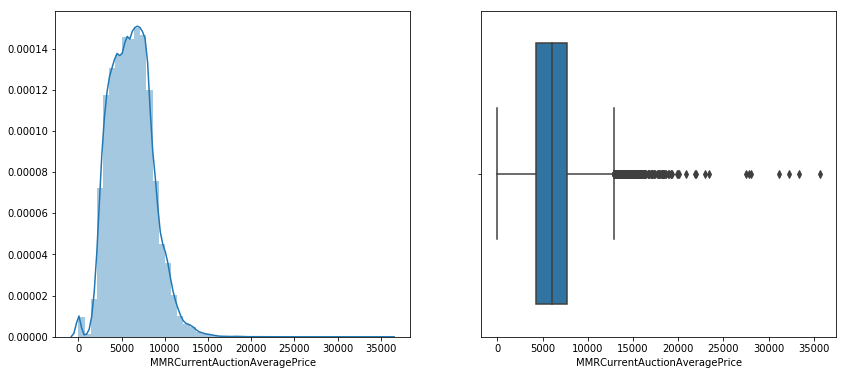

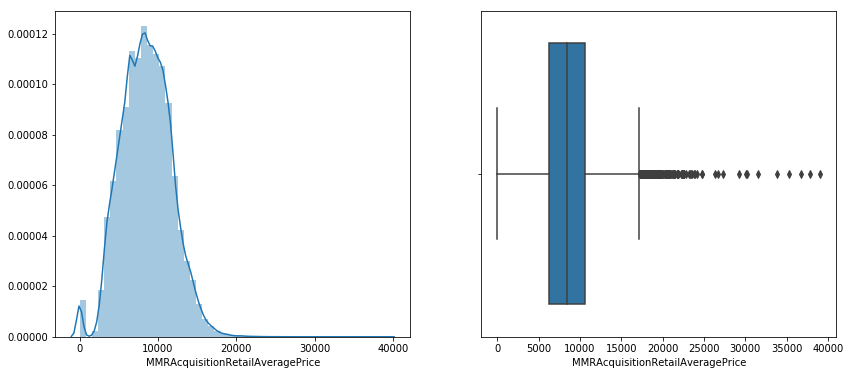

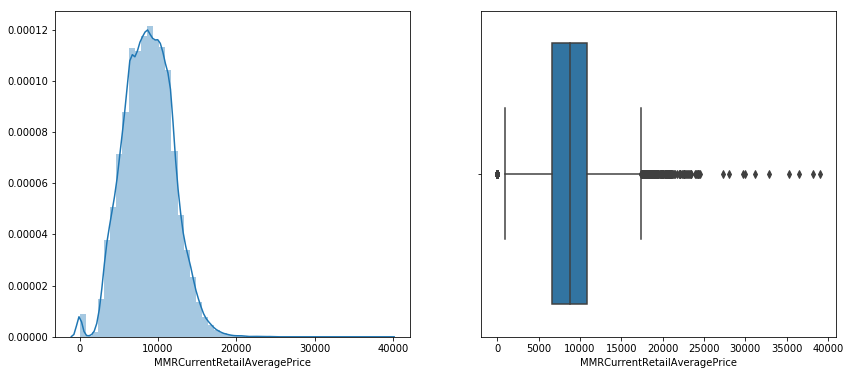

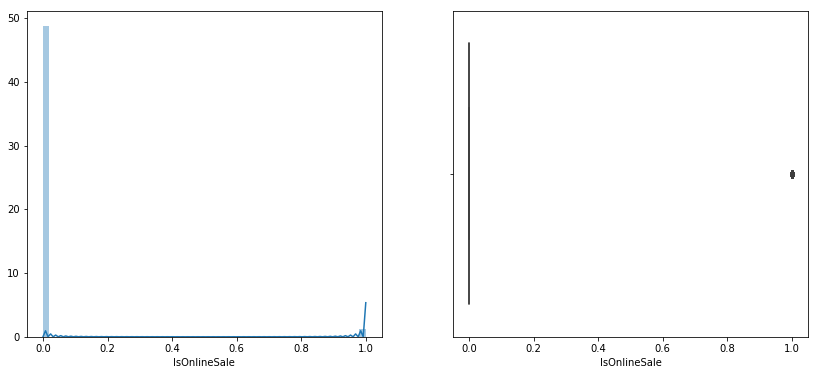

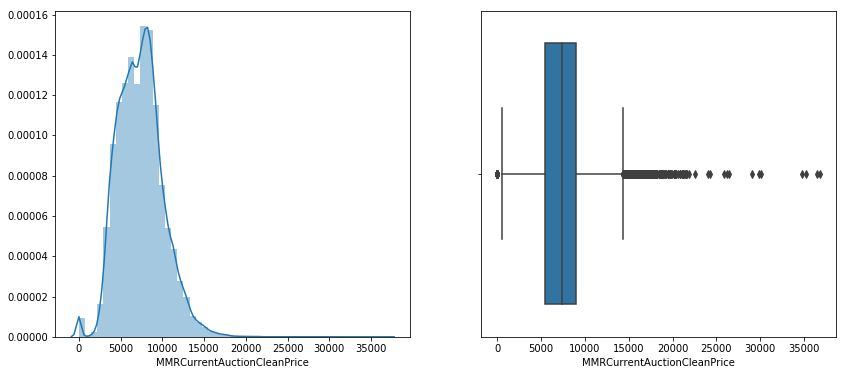

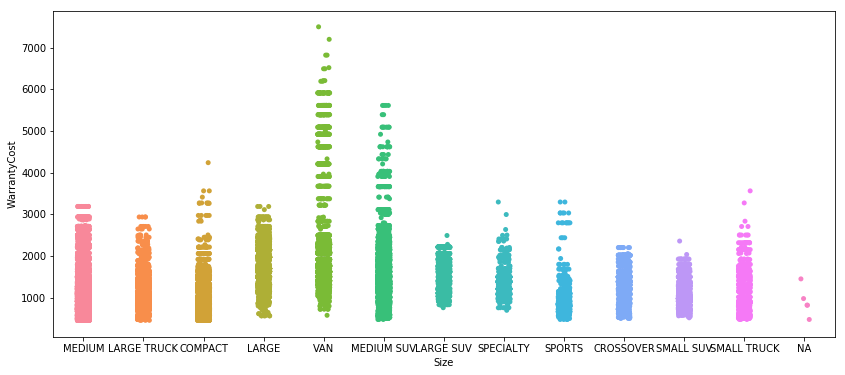

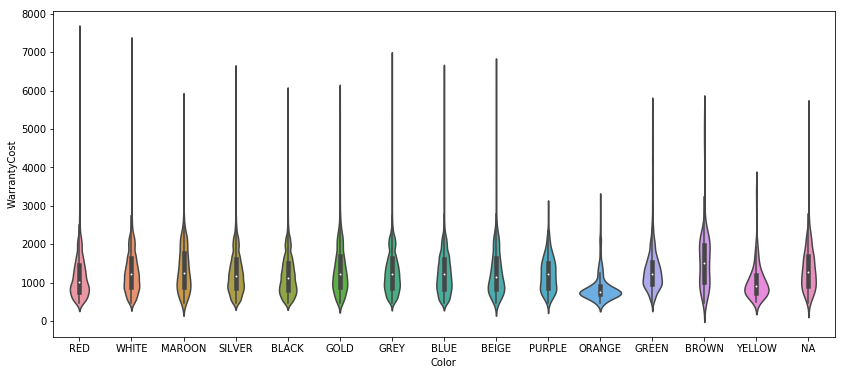

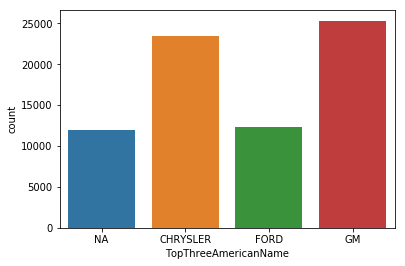

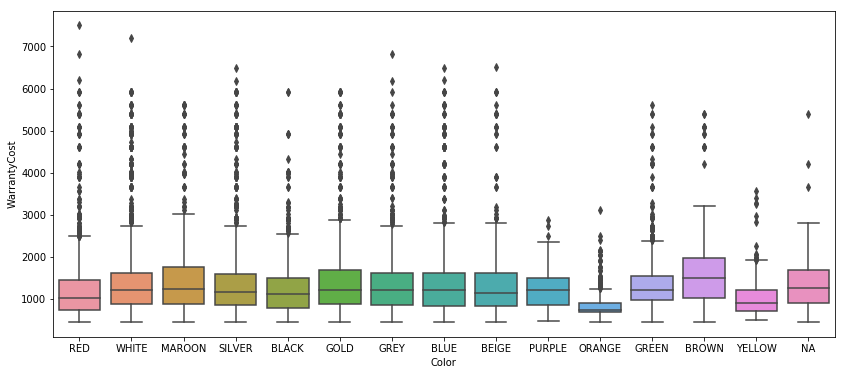

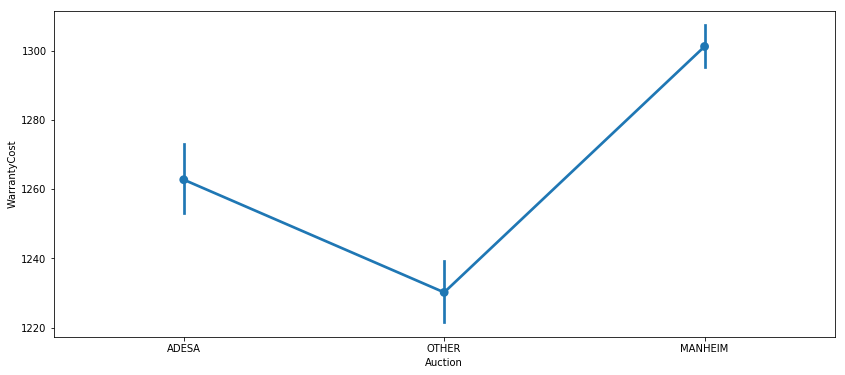

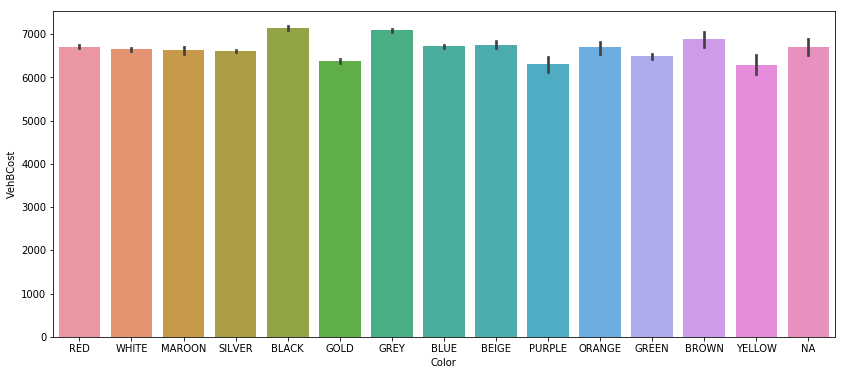

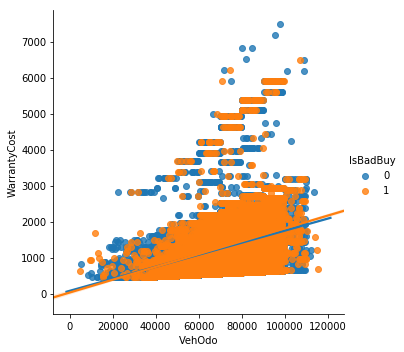

In [10]:
<a id='data2'></a>
# Correlation matrix for continuous features
def plot_corr_matrix(df):
    corr = df.corr()
    # plot the heatmap
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)
    plt.figure(figsize=(2,2))
    plt.show()

# Plotting categorical features
def plot_cat_features(df):
    plt.figure(figsize = (14, 6))
    sns.scatterplot(x='MMRAcquisitonRetailCleanPrice',y = 'MMRCurrentAuctionCleanPrice',data=df)
    plt.show()

    plt.figure(figsize = (30, 15))
    sns.lineplot(x='Make',y = 'VehicleAge',data=df)
    plt.show()

# Plotting continuous features
def plot_cont_features(df,contcols):
    for i in range (1,len(contcols)):
        plt.figure(figsize = (14, 6))
        plt.subplot(1, 2, 1)
        sns.distplot(df[contcols[i]])
        plt.subplot(1, 2, 2)
        sns.boxplot(df[contcols[i]])
        plt.show() 

    plt.figure(figsize = (14, 6))
    sns.stripplot(x='Size',y = 'WarrantyCost',data=df)
    plt.show()

    plt.figure(figsize = (14, 6))
    sns.violinplot(x='Color',y = 'WarrantyCost',data=df)
    plt.show()

    plt.figure()
    sns.countplot(x = "TopThreeAmericanName",data=df)
    plt.show()

    plt.figure(figsize = (14, 6))
    sns.boxplot(x='Color',y = 'WarrantyCost',data=df)
    plt.show()

    plt.figure(figsize = (14, 6))
    sns.pointplot(x='Auction',y = 'WarrantyCost',data=df)
    plt.show()

    plt.figure(figsize = (14, 6))
    sns.barplot(x='Color',y = 'VehBCost',data=df)
    plt.show()

    plt.figure(figsize = (14, 6))
    sns.lmplot(x='VehOdo',y = 'WarrantyCost',hue='IsBadBuy',data=df)
    plt.show()


plot_corr_matrix(df_new)
plot_cat_features(df_new)
plot_cont_features(df_new, contcols)  
    

The upper and lower bounds of WarrantyCost for suspected outliers are 2802.0 and -342.0.
Values less than lower bound : 0
Values greater than upper  bound :  838
The upper and lower bounds of MMRAcquisitionAuctionAveragePrice for suspected outliers are 13003.0 and -965.0.
Values less than lower bound : 0
Values greater than upper  bound :  526
The upper and lower bounds of VehOdo for suspected outliers are 113334.5 and 30938.5.
Values less than lower bound : 332
Values greater than upper  bound :  4
The upper and lower bounds of MMRAcquisitionAuctionCleanPrice for suspected outliers are 14442.0 and -14.0.
Values less than lower bound : 0
Values greater than upper  bound :  841
The upper and lower bounds of MMRAcquisitonRetailCleanPrice for suspected outliers are 18979.0 and 603.0.
Values less than lower bound : 828
Values greater than upper  bound :  433
The upper and lower bounds of VehicleAge for suspected outliers are 8.0 and 0.0.
Values less than lower bound : 0
Values greater than

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

The model RandomForest has AUC 0.75636923917 and STD 0.0072806041613.
The model LogisticRegression has AUC 0.691935063465 and STD 0.0104632570409.
The model LightGBM has AUC 0.752950673354 and STD 0.00963490710627.
The model XGBoost has AUC 0.744461063067 and STD 0.00844526271463.

 ---Model Summary---
Model accuracy for RandomForest = 0.831883263684
Model ROC AUC for RandomForest = 0.663648856628
             precision    recall  f1-score   support

          0       0.92      0.88      0.90     12850
          1       0.34      0.44      0.39      1747

avg / total       0.85      0.83      0.84     14597

Confusion Matrix for model RandomForest : 
 [[11370  1480]
 [  974   773]]
Model accuracy for LogisticRegression = 0.646776734946
Model ROC AUC for LogisticRegression = 0.63220640609
             precision    recall  f1-score   support

          0       0.93      0.65      0.76     12850
          1       0.19      0.61      0.29      1747

avg / total       0.84      0.65      0.

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model accuracy for LightGBM = 0.895731999726
Model ROC AUC for LightGBM = 0.595802498558
             precision    recall  f1-score   support

          0       0.90      0.99      0.94     12850
          1       0.73      0.20      0.32      1747

avg / total       0.88      0.90      0.87     14597

Confusion Matrix for model LightGBM : 
 [[12723   127]
 [ 1395   352]]


/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model accuracy for XGBoost = 0.895183941906
Model ROC AUC for XGBoost = 0.571998244907
             precision    recall  f1-score   support

          0       0.90      1.00      0.94     12850
          1       0.87      0.15      0.25      1747

avg / total       0.89      0.90      0.86     14597

Confusion Matrix for model XGBoost : 
 [[12810    40]
 [ 1490   257]]


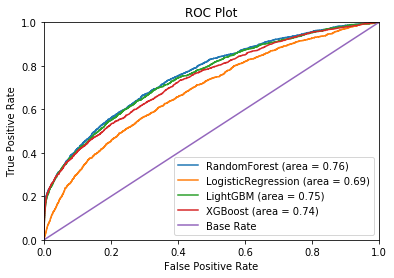

Feature importances for model RandomForest are 
                                 index  importance
0                           WheelType    0.265785
1                          VehicleAge    0.061641
2                              VehOdo    0.060472
3                            VehBCost    0.057133
4       MMRCurrentAuctionAveragePrice    0.055508
5         MMRCurrentAuctionCleanPrice    0.053165
6   MMRAcquisitionAuctionAveragePrice    0.051126
7     MMRAcquisitionAuctionCleanPrice    0.050341
8        MMRCurrentRetailAveragePrice    0.044474
9          MMRCurrentRetailCleanPrice    0.042423
10   MMRAcquisitionRetailAveragePrice    0.038699
11      MMRAcquisitonRetailCleanPrice    0.036738
12                       WarrantyCost    0.032323
13                           SubModel    0.030689
14                              Model    0.028836
15                               Trim    0.021524
16                               Make    0.016615
17                            Auction    0.015733
1

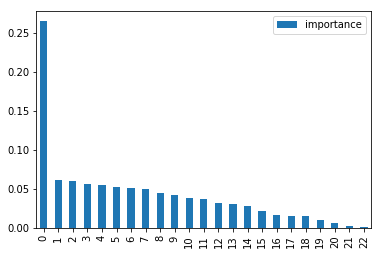

Feature importances do not exist for model LogisticRegression
Feature importances for model LightGBM are 
                                 index  importance
0                            VehBCost         642
1                          VehicleAge         639
2                             Auction         573
3                              VehOdo         459
4                           WheelType         392
5                            SubModel         333
6                               Model         270
7                                Trim         236
8                        WarrantyCost         202
9                                Make         192
10      MMRAcquisitonRetailCleanPrice         112
11    MMRAcquisitionAuctionCleanPrice         101
12         MMRCurrentRetailCleanPrice          99
13   MMRAcquisitionRetailAveragePrice          76
14       MMRCurrentRetailAveragePrice          69
15                               Size          69
16  MMRAcquisitionAuctionAveragePrice      

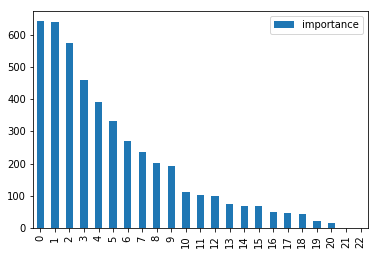

Feature importances for model XGBoost are 
                                 index  importance
0                            SubModel    0.107807
1        MMRCurrentRetailAveragePrice    0.100372
2                            VehBCost    0.100372
3       MMRCurrentAuctionAveragePrice    0.092937
4                          VehicleAge    0.081784
5       MMRAcquisitonRetailCleanPrice    0.074349
6                              VehOdo    0.070632
7                           WheelType    0.063197
8     MMRAcquisitionAuctionCleanPrice    0.055762
9                             Auction    0.052045
10                              Model    0.048327
11                               Trim    0.033457
12   MMRAcquisitionRetailAveragePrice    0.033457
13        MMRCurrentAuctionCleanPrice    0.029740
14                               Make    0.014870
15               TopThreeAmericanName    0.014870
16  MMRAcquisitionAuctionAveragePrice    0.014870
17                       Transmission    0.007435
18    

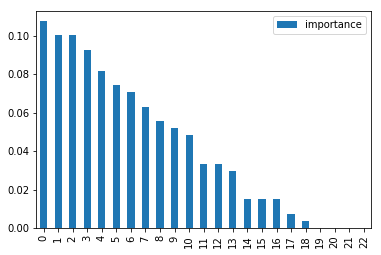

In [11]:
<a id='data3'></a>
# Define the Logistic Regression,Random Forest,XGBoost and LightGBM models.
def create_tune_models(x_train,y_train):
    models = {}
    lr = LogisticRegression(class_weight='balanced',random_state=31)
    rf = RandomForestClassifier(n_estimators=75,max_features=5,max_depth=20,
                                min_samples_split=100,class_weight='balanced',random_state=37)
    xg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, 
                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10,random_state=41)
    lgtbm = lgbm.LGBMClassifier(boosting_type='gbdt', objective='binary',
                   num_iteration=1000,num_leaves=31,
                   is_enable_sparse='true',tree_learner='data',min_data_in_leaf=600,max_depth=4,
                   learning_rate=0.01, max_bin=255, subsample_for_bin=5000, 
                   min_split_gain=5, min_child_weight=5, min_child_samples=10, subsample=0.995, 
                   subsample_freq=1, colsample_bytree=1, reg_alpha=0, 
                   reg_lambda=0, seed=0, nthread=-1, silent=True,random_state=43)
    models["LogisticRegression"] = lr
    models["RandomForest"] = rf
    models["XGBoost"] = xg
    models["LightGBM"] = lgtbm
    for k,v in models.items():
        v.fit(x_train, y_train)
        models[k]=v
    return models

# Train the models on the 10-Fold Cross Validation and calculate AUC.
def cv_models(models,x_train,y_train,kfold,metric):
    model_auc = {}
    for k,v in models.items():    
        model_results = model_selection.cross_val_score(v, x_train,y_train, cv=kfold, scoring=metric)
        mean_auc = model_results.mean()
        std = model_results.std()
        # print out the mean and standard deviation of the training score 
        print('The model {} has AUC {} and STD {}.'.format(k, mean_auc, std))
        model_auc[k] = mean_auc
    return model_auc

# Calculate and print model accuracy,confusion matrix and plot ROC curves.
def display_results(model,model_auc,x_test,y_test):          
        print ('\n ---Model Summary---')
        plt.figure()
        for k,v in model.items():
            model_predicted = v.predict(x_test)
            print ('Model accuracy for {} = {}'.format(k,accuracy_score(y_test,model_predicted)))      
            model_roc_auc = roc_auc_score(y_test, model_predicted)
            print ('Model ROC AUC for {} = {}'.format(k,model_roc_auc))
            print(classification_report(y_test, model_predicted))
            model_matrix = confusion_matrix(y_test, model_predicted)
            print('Confusion Matrix for model {} : \n {}'.format(k,model_matrix))

            fpr, tpr, thresholds = roc_curve(y_test, v.predict_proba(x_test)[:,1])           
            # plot ROC
            plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (k, model_auc[k]))
        # plot Base Rate ROC
        plt.plot([0,1], [0,1],label='Base Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Plot')
        plt.legend(loc="lower right")
        plt.show()

# Print feature importance for models.
def get_feature_importance(models,x_train):
    for k,v in models.items():
        if hasattr(v, 'feature_importances_'):
            feature_importances = pd.DataFrame(v.feature_importances_,
                                       index = x_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
            feature_importances = feature_importances.reset_index()
            print "Feature importances for model {} are \n {}".format(k,feature_importances)
            feature_importances.plot.bar()
            plt.show()    
        else:
            print "Feature importances do not exist for model",k

df_cont = get_outliers_scale(df_new, contcols)
df_cat = encode_label(df_new, catcols)
df_train = pd.concat([df_cat,df_cont,df_new[target]],axis=1)
x_train, x_test, y_train, y_test = train_test_split(df_train[features],df_train[target],test_size=0.2,random_state=7)
kfold = model_selection.KFold(n_splits=10)
metric = 'roc_auc'

models = create_tune_models(x_train, y_train)
model_auc = cv_models(models, x_train, y_train, kfold, metric)
display_results(models, model_auc, x_test, y_test)
get_feature_importance(models, x_train)      